# Thêm các thư viện cần dùng

In [1]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import joblib
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from collections import Counter
from sklearn.preprocessing import StandardScaler
from cvxopt import matrix
from cvxopt import solvers
import numpy as np
from collections import defaultdict



# TRÍCH XUẤT ĐẶC TRƯNG

Bởi bộ dữ liệu này quá lớn, vậy nên chúng tôi quyết định dùng 1 phần nhỏ của bộ data này, cụ thể là dữ liệu của năm 2015 để tiến hành phân tích và rút ra các đặc trưng quan trọng trong việc training mô hình

In [2]:
df = pd.read_csv ('./selected_columns.csv')
print(df.describe())

              _MICHD       CHOLMED3        GENHLTH       MAXVO21_  \
count  430755.000000  430755.000000  430755.000000  430755.000000   
mean        1.916600       1.744407       2.625077    4545.553744   
std         0.276486       0.610430       1.078342   12775.502758   
min         1.000000       1.000000       1.000000     555.000000   
25%         2.000000       1.000000       2.000000    2173.000000   
50%         2.000000       2.000000       3.000000    2728.000000   
75%         2.000000       2.000000       3.000000    3525.000000   
max         2.000000       9.000000       9.000000   99900.000000   

             EMPLOY1        BPHIGH6       DIABETE4       CVDSTRK3  \
count  430755.000000  430755.000000  430755.000000  430755.000000   
mean        3.899483       2.208086       2.749407       1.970830   
std         2.885213       1.047940       0.743139       0.327065   
min         1.000000       1.000000       1.000000       1.000000   
25%         1.000000       1.0000

Tiến hành xem xét thông tin của dataframe

In [3]:
#Kiểm tra các giá trị của CVDINFR4
df['CVDINFR4'].value_counts()

CVDINFR4
0    407304
1     23451
Name: count, dtype: int64

In [4]:
df = df.sample(frac=0.1, random_state=42)

In [5]:
#Kiểm tra các giá trị của CVDINFR4
df['CVDINFR4'].value_counts()

CVDINFR4
0    40757
1     2319
Name: count, dtype: int64

In [6]:

class SVM:
    def __init__(self, C=1.0, class_weight=None, max_iter=1000):
        self.C = C
        self.class_weight = class_weight if class_weight else {0: 1.0, 1: 1.0}
        self.max_iter = max_iter
        
    def fit(self, X, y):
        y = y.astype(int)
        unique_classes = np.unique(y)
        assert set(unique_classes).issubset({0, 1}), "Chỉ hỗ trợ binary classification"
        assert all(c in self.class_weight for c in unique_classes), "Thiếu class weight"

        n_samples, n_features = X.shape
        y_ = np.where(y == 0, -1, 1)
        C_i = np.array([self.C * self.class_weight[c] for c in y])
        
        K = np.dot(X, X.T)
        P = matrix(np.outer(y_, y_) * K)
        q = matrix(-np.ones(n_samples))
        
        G = matrix(np.vstack((-np.eye(n_samples), np.eye(n_samples))))
        h = matrix(np.hstack((np.zeros(n_samples), C_i)))
        A = matrix(y_.reshape(1, -1).astype('double'))
        b = matrix(0.0)
        
        # Tắt thông báo
        solvers.options['show_progress'] = False
        solvers.options['maxiters'] = self.max_iter
        
        solution = solvers.qp(P, q, G, h, A, b)
        alphas = np.array(solution['x']).flatten()
        
        sv = alphas > 1e-5
        self.alphas = alphas[sv]
        self.sv_X = X[sv]
        self.sv_y = y_[sv]

        self.b = np.mean(
            self.sv_y - 
            np.sum(self.alphas * self.sv_y * self.sv_X.dot(self.sv_X.T), axis=1)
        )
        
    def predict(self, X):
        decision = np.sum(self.alphas * self.sv_y * X.dot(self.sv_X.T), axis=1) + self.b
        return np.where(decision >= 0, 1, 0)

In [7]:

class KNN:
    def __init__(self, k=7, eps=1e-8):
        self.k = k
        self.eps = eps  # Prevents division by zero
        
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        self.classes = np.unique(y)
        
    def euclidean_distance(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2)**2 + self.eps))  # Add epsilon
    
    def predict(self, X_test):
        y_pred = []
        for x in X_test:
            # Calculate all distances
            distances = [(self.euclidean_distance(x, x_train), y_i) 
                        for x_train, y_i in zip(self.X_train, self.y_train)]
            
            # Get k nearest with distance weighting
            k_nearest = sorted(distances, key=lambda x: x[0])[:self.k]
            class_weights = defaultdict(float)
            
            for dist, label in k_nearest:
                weight = 1 / (dist + self.eps)  # Inverse distance weighting
                class_weights[label] += weight
                
            # Predict class with highest cumulative weight
            if not class_weights:
                y_pred.append(self.classes[0])  # Fallback to first class
            else:
                y_pred.append(max(class_weights, key=class_weights.get))
                
        return np.array(y_pred)
    
    def predict_proba(self, X_test):
        probas = []
        for x in X_test:
            distances = [(self.euclidean_distance(x, x_train), y_i) 
                        for x_train, y_i in zip(self.X_train, self.y_train)]
            
            k_nearest = sorted(distances, key=lambda x: x[0])[:self.k]
            class_weights = defaultdict(float)
            
            # Sum weights per class
            for dist, label in k_nearest:
                weight = 1 / (dist + self.eps)
                class_weights[label] += weight
                
            # Laplace smoothing
            total = sum(class_weights.values()) + len(self.classes)*self.eps
            probabilities = []
            
            for cls in self.classes:
                prob = (class_weights.get(cls, 0) + self.eps) / total
                probabilities.append(prob)
                
            probas.append(probabilities)
            
        return np.array(probas)

In [8]:
class DecisionTree:
    def __init__(self, max_depth=None, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        
    def _gini(self, y):
        counts = np.bincount(y)
        ps = counts / len(y)
        return 1 - np.sum([p**2 for p in ps if p > 0])
    
    def _best_split(self, X, y):
        best_feature, best_thresh = None, None
        best_gini = float('inf')
        
        for feature_idx in range(X.shape[1]):
            thresholds = np.unique(X[:, feature_idx])
            for thresh in thresholds:
                left_idx = X[:, feature_idx] <= thresh
                if np.sum(left_idx) == 0 or np.sum(~left_idx) == 0:
                    continue
                gini = (self._gini(y[left_idx]) * len(y[left_idx]) + 
                        self._gini(y[~left_idx]) * len(y[~left_idx])) / len(y)
                if gini < best_gini:
                    best_gini = gini
                    best_feature = feature_idx
                    best_thresh = thresh
        return best_feature, best_thresh
    
    def fit(self, X, y, depth=0):
        if (self.max_depth is not None and depth >= self.max_depth) or len(y) < self.min_samples_split or np.unique(y).size == 1:
            self.value = np.bincount(y).argmax()
            return
        
        self.feature_idx, self.thresh = self._best_split(X, y)
        if self.feature_idx is None:
            self.value = np.bincount(y).argmax()
            return
        
        left_idx = X[:, self.feature_idx] <= self.thresh
        if np.sum(left_idx) == 0 or np.sum(~left_idx) == 0:
            self.value = np.bincount(y).argmax()
            return
        
        self.left = DecisionTree(self.max_depth, self.min_samples_split)
        self.right = DecisionTree(self.max_depth, self.min_samples_split)
        self.left.fit(X[left_idx], y[left_idx], depth+1)
        self.right.fit(X[~left_idx], y[~left_idx], depth+1)
    
    def predict(self, X):
        if hasattr(self, 'value'):
            # Sửa ở đây: thêm dtype=int
            return np.full(X.shape[0], self.value, dtype=int)
        left_idx = X[:, self.feature_idx] <= self.thresh
        # Sửa ở đây: khởi tạo mảng với dtype=int
        y_pred = np.empty(X.shape[0], dtype=int)
        y_pred[left_idx] = self.left.predict(X[left_idx])
        y_pred[~left_idx] = self.right.predict(X[~left_idx])
        return y_pred

class RandomForest:
    def __init__(self, n_trees=200, max_depth=10):
        self.n_trees = n_trees
        self.max_depth = max_depth
        
    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            idx = np.random.choice(len(X), len(X), replace=True)
            tree = DecisionTree(max_depth=self.max_depth, min_samples_split=2)
            tree.fit(X[idx], y[idx])
            self.trees.append(tree)
    
    def predict(self, X):
        all_preds = np.array([tree.predict(X) for tree in self.trees])
        return np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=all_preds)
    
    def predict_proba(self, X):
        all_preds = np.array([tree.predict(X) for tree in self.trees])
        probas = []
        for i in range(X.shape[0]):
            prob_1 = np.mean(all_preds[:,i])
            probas.append([1-prob_1, prob_1])
        return np.array(probas)

In [9]:

class NaiveBayes:
    def __init__(self, var_smoothing=1e-9):
        self.var_smoothing = var_smoothing
        
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.means = {}
        self.vars = {}
        self.priors = {}
        
        for c in self.classes:
            X_c = X[y == c]
            self.means[c] = X_c.mean(axis=0)
            self.vars[c] = X_c.var(axis=0) + self.var_smoothing  # Prevent zero variance
            self.priors[c] = len(X_c) / len(X)
    
    def _log_gaussian_pdf(self, x, mean, var):
        # Directly compute log PDF without exponentiating
        return -0.5 * (np.log(2 * np.pi * var) + (x - mean)**2 / var)
    
    def predict(self, X):
        posteriors = []
        for c in self.classes:
            prior = np.log(self.priors[c])
            # Use log-PDF directly and sum over features
            log_likelihood = np.sum(self._log_gaussian_pdf(X, self.means[c], self.vars[c]), axis=1)
            posterior = prior + log_likelihood
            posteriors.append(posterior)
        posteriors = np.array(posteriors).T
        return self.classes[np.argmax(posteriors, axis=1)]

In [10]:


class NeuralNetwork:
    def __init__(self, input_size, class_weight=None):
        self.W1 = np.random.randn(input_size, 64) * np.sqrt(2./input_size)
        self.b1 = np.zeros(64)
        self.W2 = np.random.randn(64, 32) * np.sqrt(2./64)
        self.b2 = np.zeros(32)
        self.W3 = np.random.randn(32, 1) * np.sqrt(2./32)
        self.b3 = np.zeros(1)
        self.class_weight = class_weight or {0:1, 1:1}
        self.eps = 1e-7  # Added epsilon for numerical stability
        
    def relu(self, x):
        return np.maximum(0, x)
    
    def sigmoid(self, x):
        # Numerically stable sigmoid
        positive_mask = (x >= 0)
        negative_mask = ~positive_mask
        result = np.zeros_like(x)
        exp_neg_x = np.exp(-x[positive_mask])
        result[positive_mask] = 1.0 / (1.0 + exp_neg_x)
        exp_x = np.exp(x[negative_mask])
        result[negative_mask] = exp_x / (1.0 + exp_x)
        return result
    
    def forward(self, X):
        self.z1 = X.dot(self.W1) + self.b1
        self.a1 = self.relu(self.z1)
        self.z2 = self.a1.dot(self.W2) + self.b2
        self.a2 = self.relu(self.z2)
        self.z3 = self.a2.dot(self.W3) + self.b3
        return self.sigmoid(self.z3)
    
    def compute_loss(self, y, y_pred):
        y = y.reshape(-1, 1)
        weights = np.vectorize(lambda x: self.class_weight[x])(y)
        # Clip predictions to avoid log(0)
        y_pred = np.clip(y_pred, self.eps, 1 - self.eps)
        return -np.mean(weights * (y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred)))
    
    def fit(self, X, y, epochs=100, lr=0.01):
        m = X.shape[0]  # Number of samples
        for epoch in range(epochs):
            # Forward pass
            y_pred = self.forward(X)
            
            # Backpropagation
            weights = np.vectorize(lambda x: self.class_weight[x])(y).reshape(-1,1)
            grad_z3 = (y_pred - y.reshape(-1,1)) * weights / m  # Scale by batch size
            
            grad_W3 = self.a2.T.dot(grad_z3)
            grad_b3 = np.sum(grad_z3, axis=0)
            
            grad_a2 = grad_z3.dot(self.W3.T)
            grad_z2 = grad_a2 * (self.z2 > 0)
            grad_W2 = self.a1.T.dot(grad_z2)
            grad_b2 = np.sum(grad_z2, axis=0)
            
            grad_a1 = grad_z2.dot(self.W2.T)
            grad_z1 = grad_a1 * (self.z1 > 0)
            grad_W1 = X.T.dot(grad_z1)
            grad_b1 = np.sum(grad_z1, axis=0)
            
            # Update parameters
            self.W3 -= lr * grad_W3
            self.b3 -= lr * grad_b3
            self.W2 -= lr * grad_W2
            self.b2 -= lr * grad_b2
            self.W1 -= lr * grad_W1
            self.b1 -= lr * grad_b1

In [11]:

# Chuẩn bị dữ liệu
X = df.drop('CVDINFR4', axis=1)
y = df['CVDINFR4']

# Chia tập train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


X_train_svm = X_train.sample(frac=0.1, random_state=42)  # Giữ lại 10%
y_train_svm = y_train.loc[X_train_svm.index]  # Lấy y tương ứng


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_svm)
X_test_scaled = scaler.transform(X_test)

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['No CVD', 'CVD'], yticklabels=['No CVD', 'CVD'])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()
# Hàm đánh giá
def evaluate_model(y_true, y_pred, model_name):
    print(f"Đánh giá cho {model_name}:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")
    plot_confusion_matrix(y_true, y_pred, model_name)


Đánh giá cho KNN:
Accuracy: 0.9442
Precision: 0.2692
Recall: 0.0201
F1 Score: 0.0374


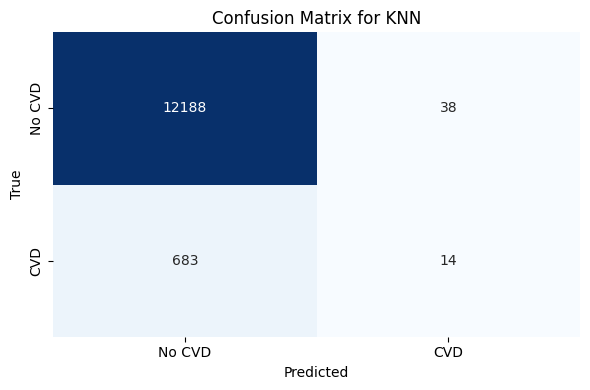

In [12]:
knn = KNN(k=7)
knn.fit(X_train.values, y_train.values)
y_pred_knn = knn.predict(X_test.values)
evaluate_model(y_test, y_pred_knn, "KNN")

Đánh giá cho Naive Bayes:
Accuracy: 0.9713
Precision: 0.6526
Recall: 1.0000
F1 Score: 0.7898


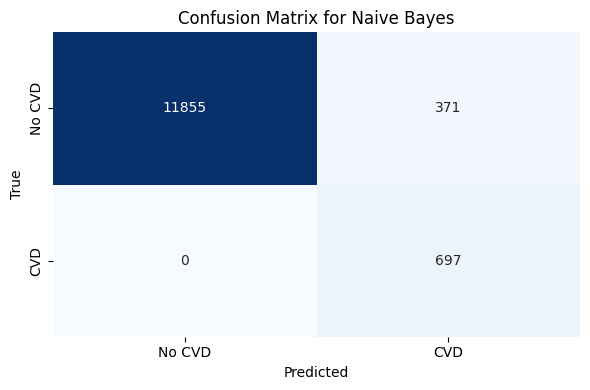

In [13]:
nb = NaiveBayes(var_smoothing=1e-9)
nb.fit(X_train.values, y_train.values)
y_pred_nb = nb.predict(X_test.values)
evaluate_model(y_test, y_pred_nb, "Naive Bayes")

CVDINFR4
0    40757
1     2319
Name: count, dtype: int64
Đánh giá cho Neural Network:
Accuracy: 0.9461
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


/Users/jun/Downloads/WORKSPACE/TensorFlow/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


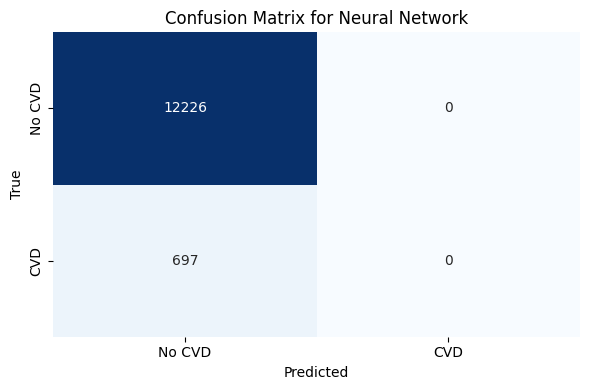

In [24]:
print(df['CVDINFR4'].value_counts())
class_weight = {0: 1, 1: 17.57}# Cân bằng lớp
ann = NeuralNetwork(input_size=X_train.shape[1], class_weight=class_weight)
ann.fit(X_train.values, y_train.values, epochs=100, lr=0.01)
y_proba_ann = ann.forward(X_test.values).flatten()
y_pred_ann = (y_proba_ann >= 0.5).astype(int)
evaluate_model(y_test, y_pred_ann, "Neural Network")

Đánh giá cho Random Forest:
Accuracy: 0.9683
Precision: 0.6515
Recall: 0.8852
F1 Score: 0.7506


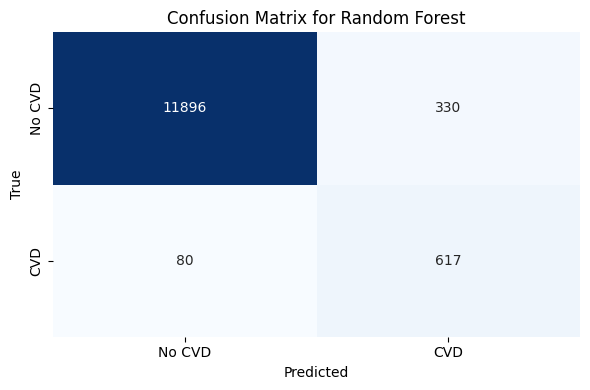

In [15]:
rf = RandomForest(n_trees=200)
rf.fit(X_train.values, y_train.values)
y_pred_rf = rf.predict(X_test.values)
evaluate_model(y_test, y_pred_rf, "Random Forest")

Đánh giá cho SVM:
Accuracy: 0.9710
Precision: 0.6510
Recall: 0.9957
F1 Score: 0.7873


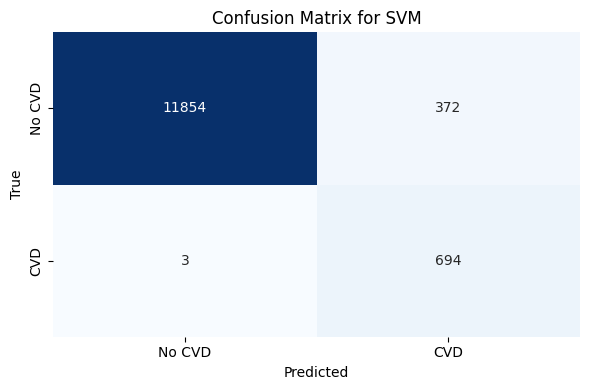

In [16]:
svm = SVM(
    C=31.418972875029368,
    class_weight={0: 1, 1: 18},
    max_iter=1000
)
svm.fit(X_train_scaled, y_train_svm.values)
y_pred_svm = svm.predict(X_test_scaled)
evaluate_model(y_test, y_pred_svm, "SVM")

In [17]:

joblib.dump(knn, '_knn.pkl')
joblib.dump(nb, '_nb.pkl')
joblib.dump(rf, '_rf.pkl')
joblib.dump(svm, '_svm.pkl')
joblib.dump(ann, '_ann.pkl')

['_ann.pkl']